# Introduction to Pandas, Part 2


Let's start by loading the California baby names again.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sns
# sns.set()

from IPython.display import display
import urllib.request
import os.path
import zipfile

data_url = "https://www.ssa.gov/oact/babynames/state/namesbystate.zip"
local_filename = "../week_2/babynamesbystate.zip"
if not os.path.exists(local_filename): # if the data exists don't download again
    with urllib.request.urlopen(data_url) as resp, open(local_filename, 'wb') as f:
        f.write(resp.read())

zf = zipfile.ZipFile(local_filename, 'r')

ca_name = 'CA.TXT'
field_names = ['State', 'Sex', 'Year', 'Name', 'Count']
with zf.open(ca_name) as fh:
    babynames = pd.read_csv(fh, header=None, names=field_names)

babynames.sample(5)

# Grouping and Aggregating



To understand how groupby works, consider the visual diagram below. The `groupby` function clusters rows from the original dataframe into groups (which I call subframes). The `agg` function then condenses each subframe into a single representative row using the provided function f.

![image](groupby_picture.png)
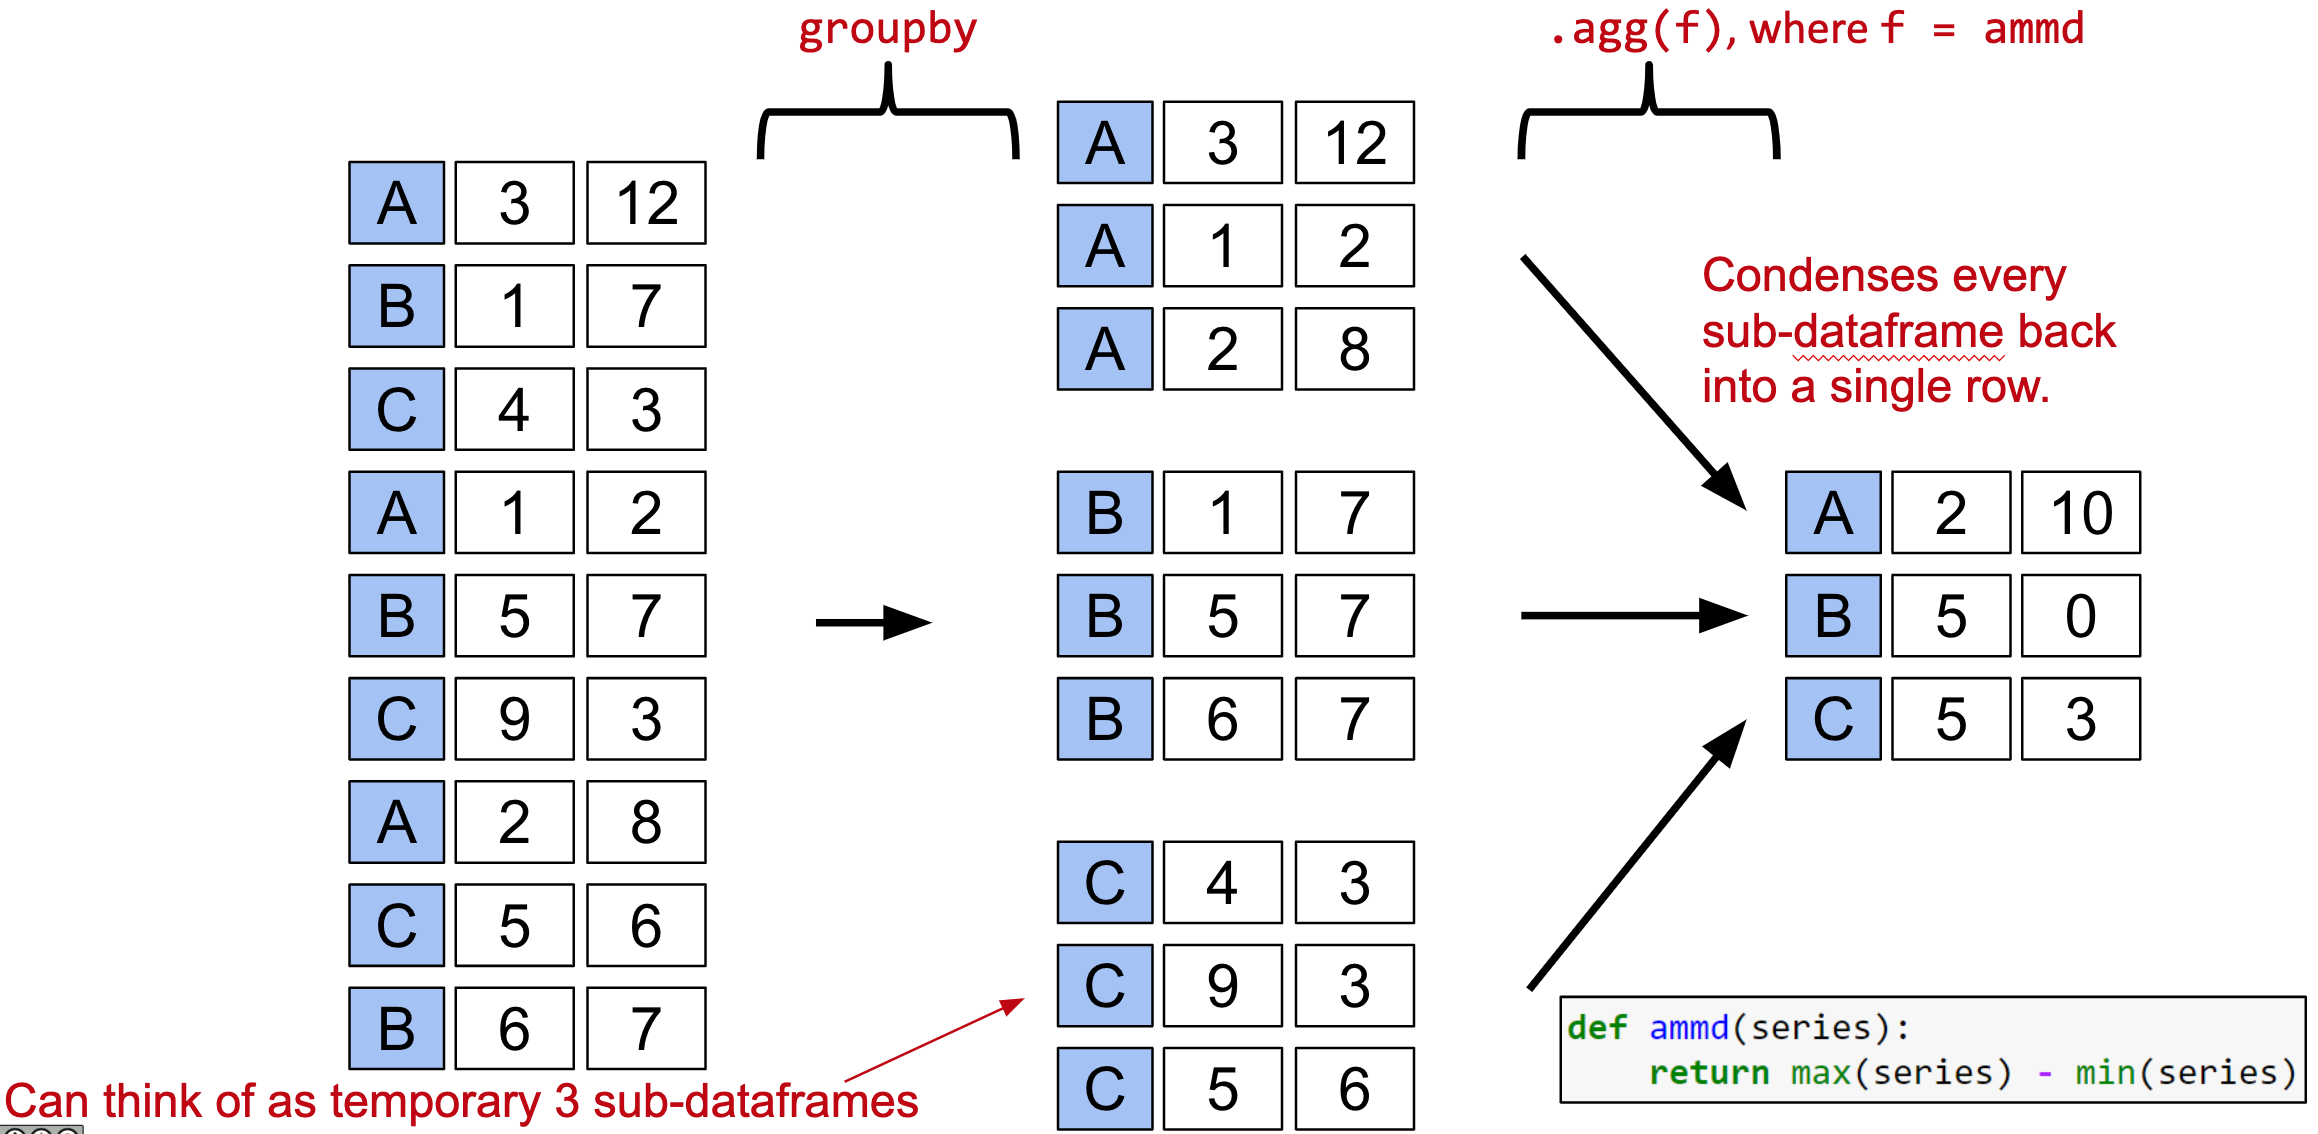

Let's actually build this DataFrame and play with it interactively to understand `groupby` a little better:

In [ ]:
d = pd.DataFrame(dict(x=[3,1,4,1,5,9,2,5,6], y=[12,7,3,2,7,3,8,6,7]), index=list('ABCABCACB') )
d

In [ ]:
dgb = d.groupby(d.index)
dgb

In [ ]:
dgb.groups

In [ ]:
dgb.groups['A']

In [ ]:
dgb.get_group('A')

---

To test your understanding, try to interpret the result of the code below.

In [ ]:
babynames[ ["Year","Count"] ].groupby("Year").agg(max).plot();

For reference, the first 5 values from the plot above are:

In [ ]:
babynames[ ["Year","Count"] ].groupby("Year").agg(sum).head(5)

## groupby warning

It is easy to get unexpected things.  Groupby is a powerful command that can do a lot of data manipulations but it is easy to get results you don't intend. 

Let's switch dataset quickly and look at the US Presidential elections again.  Suppose you want to know the best election result that each political party achieved.  

In [ ]:
elections = pd.read_csv("elections.csv")
elections.sample(5)

We have to be careful when using aggregation functions. For example, the code below might be misinterpreted to say that Woodrow Wilson ran for election in 2016. Why is this happening?

In [ ]:
elections.groupby("Party").agg(max).head(10)

### groupby fix

Next we'll write code that properly returns _the best result by each party_. That is, each row should show the Year, Candidate, Popular Vote, Result, and % for the election in which that party saw its best results (rather than mixing them and treating every column independently as in the example above), here's what the first rows of the correct output should look like:

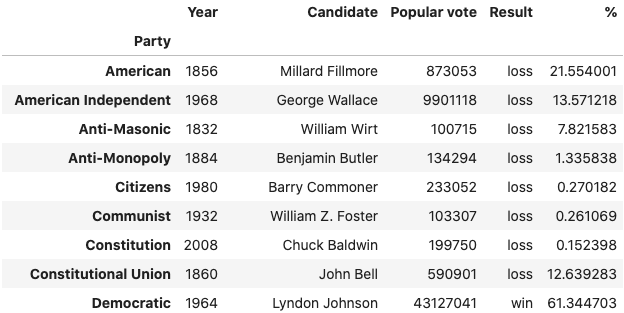

In [ ]:
elections_sorted_by_percent = elections.sort_values("%", ascending=False)
elections_sorted_by_percent.head(5)

We used the agg(max) method to  combine above. Instead, now that we have a sorted table it is now simply a matter of taking the first() row and ignoring all the others.    

In [ ]:
    
elections_sorted_by_percent = elections.sort_values("%", ascending=False)
elections_sorted_by_percent.groupby("Party").first()

You'll soon discover that with Pandas' rich tool set, there's typically more than one way to get to the same answer. Each approach has different tradeoffs in terms of readability, performance, memory consumption, complexity and more.  It will take some experience for you to develop a sense of which approach is better for each problem, but you should in general try to think if you can at least envision a different solution to a given problem, especially if you find your current solution to be particularly convoluted or hard to read.


---

## Other groupby Features

### groupby.size()

In [ ]:
elections.groupby("Party")

In [ ]:
#size returns a Series giving the size of each group
elections.groupby("Party").size().head(15)

### groupby.filter()

In [ ]:
# filter gives a copy of the original DataFrame where row r is included
# if its group obeys the given condition
#
# Note: Filtering is done per GROUP, not per ROW.
elections.groupby("Year").filter(lambda sf: sf["%"].max() < 45)

In [ ]:
for i, (n, g) in enumerate(elections.groupby("Party")):
    print(n)
    display(g.head(2))
    if i>3: break

### groupby.sum(), groupby.mean(), etc.

As an alternative to groupby.agg(sum), we can also simply do groupby.sum().

In [ ]:
elections.groupby("Year").agg(sum).head()

In [ ]:
elections.groupby("Year").sum().head()

The same applies for many other common operations.

In [ ]:
elections.groupby("Year").agg(max).head()

In [ ]:
elections.groupby("Year").max().head()

In [ ]:
#elections.groupby("Year").mean().head()
elections.groupby("Year").median().head()
#elections.groupby("Year").max().head()

# Grouping by more than one thing
# Hierarchical indexing

Groupby() is not just limited to 1 column name you can create an index with multiple columns too. 





In [ ]:
babynames.groupby(["Year", "Sex"]).agg(sum).head(6)

In [ ]:
babynames.groupby(["Sex", "Year"]).agg(sum).head(6)

Suppose we want to build a table showing the total number of babies born of each sex in each year. One way is to groupby using both columns of interest.

In [ ]:
babynames.groupby(["Year", "Sex"]).agg(sum).head(6)

#Slicing

In order to select things in the multi index you need to use python "slice" syntax.  We did that last week.  But it gets fiddly with a multi index. 

Remember how we could use start:end to select a range?  You can do the same with a multi index.   But it's funky because a multiple index has multiple things.   


In [ ]:
babyGrouped = babynames.groupby(["Year", "Sex"],).agg(max)





In [ ]:
#Slice Example
babyGrouped.loc[ (2010,'M') ,slice(None)]

babyGrouped.loc[ (2010,'M'):(2012,'F') ,slice(None)]


In [ ]:
#Cross Section
babyGrouped.xs('F',level='Sex')

## Resetting the index

Sometimes instead of using the multi index it's easier to just reset the index.  That puts the index values back into the columns. 

### WARNING Output vs. changing things

Most of these commands are not -changing- the dataframe.  You need to specifically do that. 

In [ ]:
babyGrouped.reset_index()


In [ ]:
babyGrouped

In [ ]:
babyGroupedReset = babyGrouped.reset_index()
babyGrouped.reset_index(inplace=True)


## Pivot Tables

Pivot tables are another way to reformat and group data.  They are a different syntax that some find more natural. Especially if you've used the function in Excel before.  When grouping more than one thing they can be easier to work with.    

Suppose we want to build a table showing the total number of babies born of each sex in each year. One way is to groupby using both columns of interest.

In [ ]:
babynames.groupby(["Year", "Sex"]).agg(sum).head(6)

Another way is to use a "Pivot Table".   

In [ ]:
babynames_pivot = babynames.pivot_table( index='Year', columns='Sex', values=['Count'], aggfunc=np.max, )
babynames_pivot.head()

THat line of code is getting complicated and hard to read.   Let's use formatting to make it simpler.  Below is exactly the same code

In [ ]:
babynames_pivot = babynames.pivot_table(
    index='Year', # the rows (turned into index)
    columns='Sex', # the column values
    values=['Count'], # the field(s) to processed in each group
    aggfunc=np.sum, # group operation
)
babynames_pivot.tail()

Further, with data structured this way making comparisons plots becomes straightforward.



In [ ]:
babynames_pivot = babynames.pivot_table(
    index='Year', # the rows (turned into index)
    columns='Sex', # the column values
    values=['Count'], # the field(s) to processed in each group
    aggfunc=np.sum, # group operation
)
babynames_pivot.plot()



Notice anything in that plot?

### Excercises:  

## Grouping

More careful look at the most popular 2018 name in California.
In last weeks tasks for popular names, we didn't take into account the unlikely possibility that the most popular name was actually spread across both birth sexes. For example, what if in the table below it turns out that there were 300 female Noahs born in CA in 2018? In that case, Noah would actually be the most popular.

Since our queries are getting pretty long, I've stuck them inside parentheses which allows us to spread them over many lines.

In [ ]:
(
babynames[babynames["Year"] == 2018]
    .sort_values(by = "Count", ascending = False)
    .head(5)
)

Try to add a single line to the operation above so that each row represents the sum of male and female babies born in 2018 with that name. To do this, fill in the ??? below.

In [ ]:
(
babynames[babynames["Year"] == 2018]
    #.???
    #.???   
    .sort_values(by = "Count", ascending = False)
    .head(5)
)

Can you make a table that lists the #1 names for the years 2000-2010?

How many  babys in total were born in 1940? in 2020?

Try ploting this use .plot() instead of selecting a year

Before we were looking at the differences in popularity.  Considering the total numbers of babys born does this have any implications for how we should inpterpret our previous analysis above? 



Can you make a plot of the number of unique names given over the years? This one is harder and requires using a function we didn't use above.  


What other things can you think of?   Try and think of a question. 